# **Faster R-CNN**

# **Assignment-4**

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Download the pretrained model from torchvision with Line 2 will download a pretrained Resnet50 Faster R-CNN model with pretrained weights.

In [2]:
import torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 60.2MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       

Define the class names given by PyTorch’s official Docs.                     
We can see some N/A’s in the list, as a few classes were removed in the later papers. We will go with the list given by PyTorch.

In [0]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush' 
]

## **Prediction of the model**

Let’s define a function to get the image path and get the prediction of the image by the model.
                                                                              

               
                        


*  Image is obtained from the image path   
*  The image is converted to image tensor using PyTorch’s Transforms  
*   Image is passed through the model to get the predictions
*   Class, box coordinates are obtained, but only prediction score > threshold are chosen.


In [0]:
from PIL import Image
import torchvision.transforms as T

def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model([img]) # Pass the image to the model
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class

## **Pipeline for Object Detection**

Next we will define a pipeline to get the image path and get the output image.


*   Prediction is obtained from get_prediction method


*   For each prediction, bounding box is drawn and text is written
with opencv


*   The final image is displayed


In [0]:
import cv2
import matplotlib.pyplot as plt

In [0]:
def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
 
  boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  plt.figure(figsize=(20,30)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

## **Inference**

Now lets use the API pipleine which we built to detect object in some images. The pretrained Model takes around 8 seconds for inference in CPU and 0.15 second in NVIDIA GTX 1080 Ti GPU.

- A. Download an image for inference

In [7]:
!wget https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg -O people.jpg

--2019-11-23 01:03:25--  https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg
Resolving www.wsha.org (www.wsha.org)... 104.198.7.33
Connecting to www.wsha.org (www.wsha.org)|104.198.7.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1923610 (1.8M) [image/jpeg]
Saving to: ‘people.jpg’

people.jpg          100%[===================>]   1.83M  --.-KB/s    in 0.09s   

2019-11-23 01:03:26 (21.1 MB/s) - ‘people.jpg’ saved [1923610/1923610]



- B. Use the image with the api function to display the output.

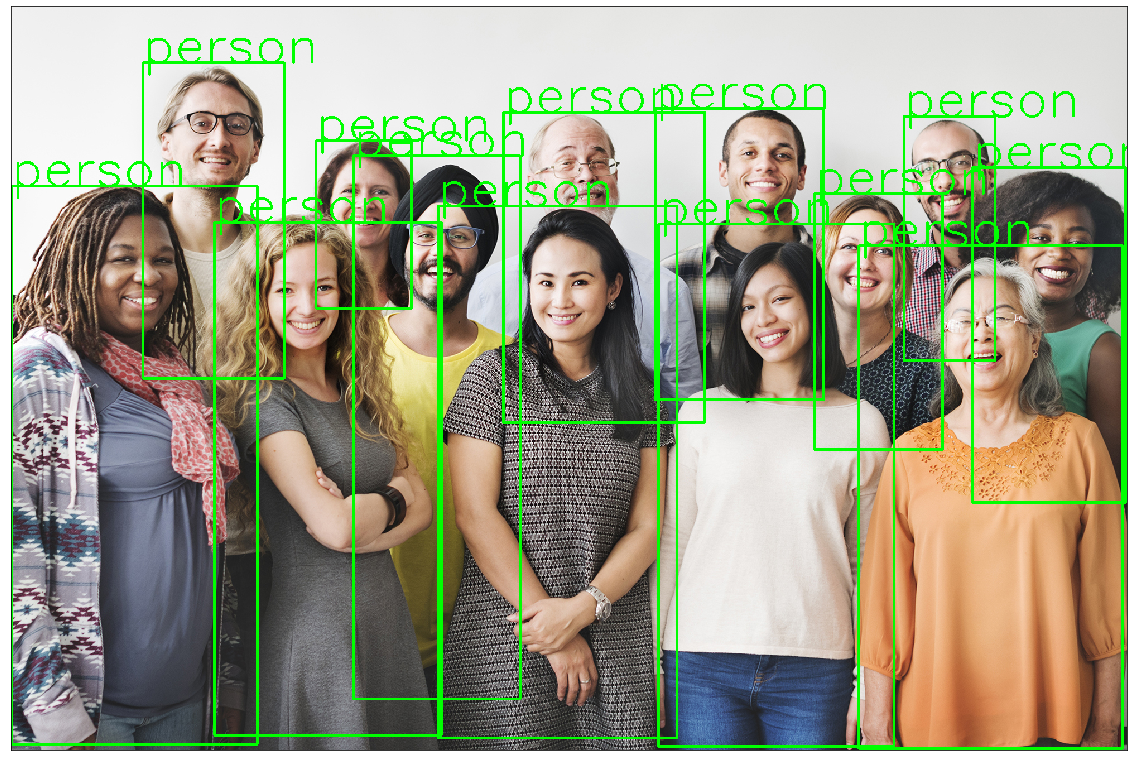

In [8]:
object_detection_api('./people.jpg', threshold=0.8)

In [9]:
!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg -O car.jpg
 
object_detection_api('./car.jpg', rect_th=6, text_th=5, text_size=5)

Output hidden; open in https://colab.research.google.com to view.

--2019-11-23 01:03:54--  https://cdn.pixabay.com/photo/2013/07/05/01/08/traffic-143391_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.141.87, 104.18.82.97, 2606:4700::6812:5261, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.141.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253264 (247K) [image/jpeg]
Saving to: ‘traffic.jpg’

traffic.jpg         100%[===================>] 247.33K  --.-KB/s    in 0.1s    

2019-11-23 01:03:55 (2.51 MB/s) - ‘traffic.jpg’ saved [253264/253264]



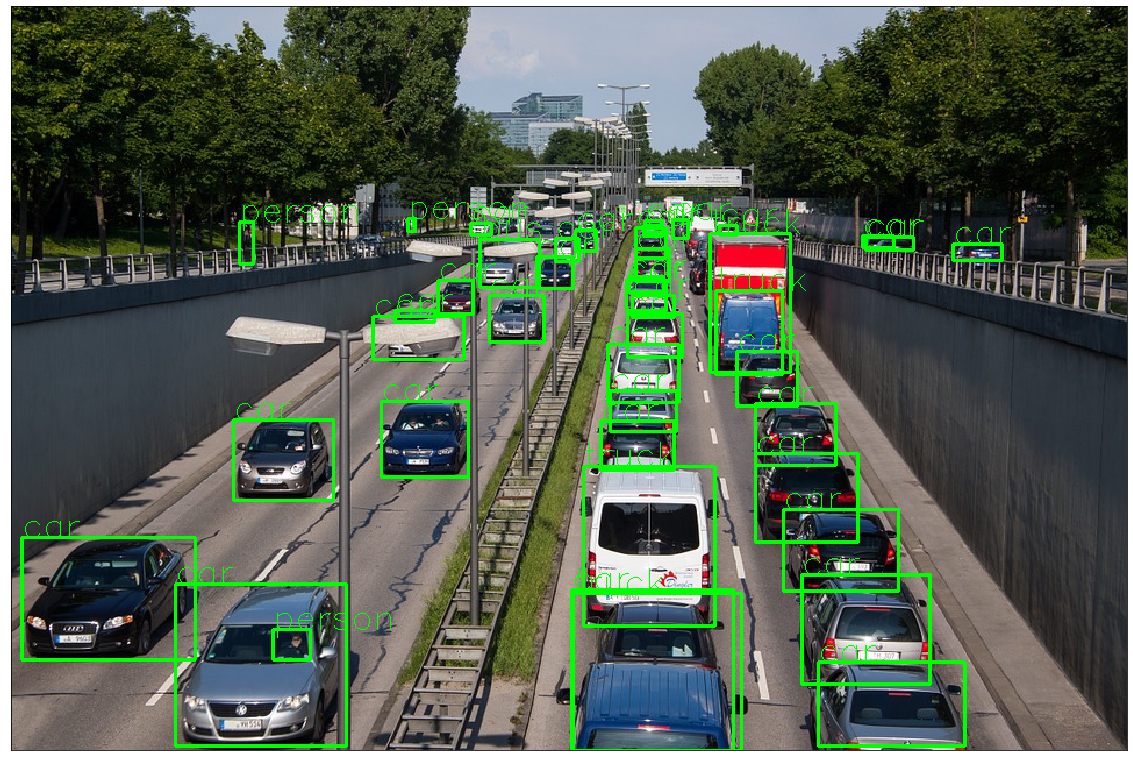

In [10]:
!wget https://cdn.pixabay.com/photo/2013/07/05/01/08/traffic-143391_960_720.jpg -O traffic.jpg
 
object_detection_api('./traffic.jpg', rect_th=2, text_th=1, text_size=1)

--2019-11-23 01:04:06--  https://images.unsplash.com/photo-1458169495136-854e4c39548a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.54.208, 2a04:4e42:d::720
Connecting to images.unsplash.com (images.unsplash.com)|151.101.54.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1168686 (1.1M) [image/jpeg]
Saving to: ‘girl_cars.jpg’

girl_cars.jpg       100%[===================>]   1.11M  --.-KB/s    in 0.05s   

2019-11-23 01:04:07 (24.4 MB/s) - ‘girl_cars.jpg’ saved [1168686/1168686]



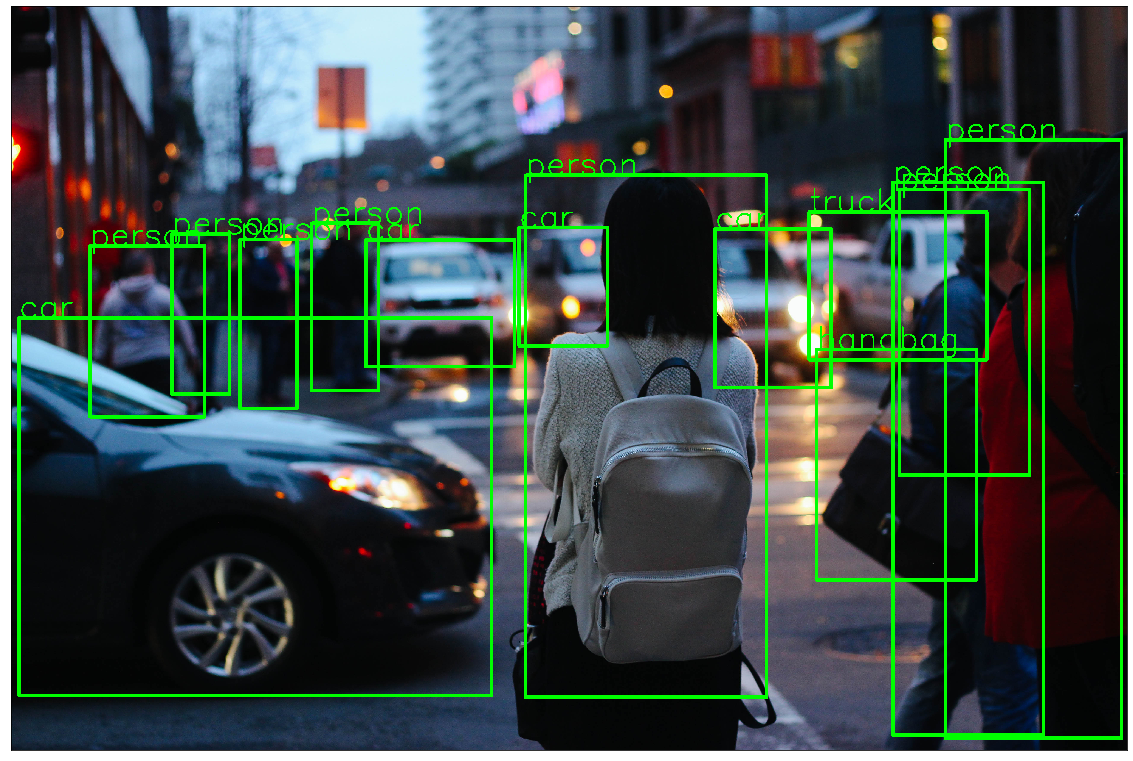

In [11]:
!wget https://images.unsplash.com/photo-1458169495136-854e4c39548a -O girl_cars.jpg
 
object_detection_api('./girl_cars.jpg', rect_th=15, text_th=7, text_size=5, threshold=0.8)